In [1]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from scipy.cluster.hierarchy import linkage, fcluster

In [2]:
# Preprocessing the data 
df = pd.read_csv('cars.csv')

# **droping the columns which are not need for linear Regression and classification purpose.**
# 1.'Engine Information.Hybrid' as this column has only one value which is 'Hybrid' so doesn't affect as prediction
# 2.'Engine Information.Transmission' this is redundant column as we have one more column called classification which 
# have same information
# 3.'Identification.Model Year' this column is also redundant as we have separate column which has this information

df.drop(['Engine Information.Hybrid','Engine Information.Transmission','Identification.Model Year'],axis=1,inplace=True)

In [3]:
# converting categorical column into integer column by adding new column for each class of category and droping 
# one of the column from that to avoid dependency of columns
dummy = pd.get_dummies(df[['Engine Information.Driveline','Fuel Information.Fuel Type','Identification.Classification']],drop_first = True)

# combining the new columns to original dataframe
df = pd.concat([df,dummy],axis=1)

In [4]:

# Remaming the column name to make them shorter, more understandable, and easy to use for later purposes. 
df.rename(columns = {'Dimensions.Height':'DimensionsHeight','Dimensions.Length': 'DimensionsLength', 
                     'Dimensions.Width':'DimensionsWidth',
       'Engine Information.Engine Type':'Engine_Type',
       'Engine Information.Driveline':'Driveline',
       'Engine Information.Number of Forward Gears':'ForwardGears',
       'Fuel Information.City mpg':'CityMPG', 'Fuel Information.Highway mpg':'HighwayMPG',
       'Identification.ID':'IdentificationID', 'Identification.Make':'Make',
       'Identification.Year':'Year',
       'Fuel Information.Fuel Type':'FuelType',
       'Identification.Classification':'Classification',
       'Engine Information.Engine Statistics.Horsepower':'Horsepower',
       'Engine Information.Engine Statistics.Torque':'Torque',
       'Engine Information.Driveline_Four-wheel drive':'Four-wheelDrive',
       'Engine Information.Driveline_Front-wheel drive':'Front-wheelDrive',
       'Engine Information.Driveline_Rear-wheel drive':'Rear-wheelDrive', 
       'Fuel Information.Fuel Type_Diesel fuel':'FuelType_Diesel',
       'Fuel Information.Fuel Type_E85':'FuelType_E85', 
       'Fuel Information.Fuel Type_Gasoline':'FuelType_Gasoline',
       'Identification.Classification_Manual transmission':'Classification_ManualTransmission'},inplace=True)

In [5]:
# Adding one more column which gives information about the no of cylinder car has which is present in other column 
# which other information so extracting and then putting it to new column

#getting cylinder number from engine type description.
df['Cylinder'] = df.apply(lambda row: re.split(' cy*',str(row.Engine_Type).lower())[0].split()[-1], axis = 1)

# this we found after quering the unique value of the column. 
# dropping rows where cylinder is not present as there are only 16 such obervations. 
df = df[~df['Cylinder'].isin(['diesel','ft-lbs'])]
df['Cylinder'] = df['Cylinder'].astype(str).astype(int)

#Creating one more column which might be usual predictor variable of meliage i.e. how many year old that model is
df['YearsOld'] = df.apply(lambda row: (datetime.now().year) - int(row.Year),axis=1)
df.reset_index(inplace= True)

In [6]:
df.describe()

,index,DimensionsHeight,DimensionsLength,DimensionsWidth,ForwardGears,CityMPG,HighwayMPG,Year,Horsepower,Torque,Four-wheelDrive,Front-wheelDrive,Rear-wheelDrive,FuelType_Diesel,FuelType_E85,FuelType_Gasoline,Classification_ManualTransmission,Cylinder,YearsOld
count,5060.000000,5060.000000,5060.000000,5060.000000,5060.000000,5060.000000,5060.000000,5060.000000,5060.000000,5060.000000,5060.000000,5060.000000,5060.000000,5060.000000,5060.000000,5060.000000,5060.000000,5060.000000,5060.000000
mean,2537.148024,145.724308,127.931423,143.900791,5.517589,17.283597,24.135178,2010.867787,270.355336,272.773123,0.181621,0.310079,0.343083,0.005138,0.090119,0.904348,0.220751,6.108498,8.132213
std,1466.311480,62.069662,77.428315,79.924851,0.846540,4.482776,6.494688,0.783118,95.098198,100.044251,0.385570,0.462571,0.474786,0.071505,0.286380,0.294143,0.414794,1.754752,0.783118
min,0.000000,1.000000,2.000000,1.000000,4.000000,8.000000,11.000000,2009.000000,100.000000,98.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,7.000000
25%,1265.750000,104.000000,60.000000,62.000000,5.000000,14.000000,20.000000,2010.000000,189.000000,190.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,4.000000,8.000000
50%,2540.500000,152.000000,128.000000,158.000000,6.000000,17.000000,24.000000,2011.000000,266.000000,260.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,6.000000,8.000000
75%,3807.250000,193.000000,199.000000,219.000000,6.000000,20.000000,28.000000,2011.000000,317.000000,335.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,8.000000,9.000000
max,5075.000000,255.000000,255.000000,254.000000,8.000000,38.000000,223.000000,2012.000000,638.000000,774.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,10.000000


In [7]:
print(df['FuelType'].unique())
print(df['Driveline'].unique())
print(df['Classification'].unique())

['Gasoline' 'E85' 'Diesel fuel' 'Compressed natural gas']
['All-wheel drive' 'Front-wheel drive' 'Rear-wheel drive'
 'Four-wheel drive']
['Automatic transmission' 'Manual transmission']


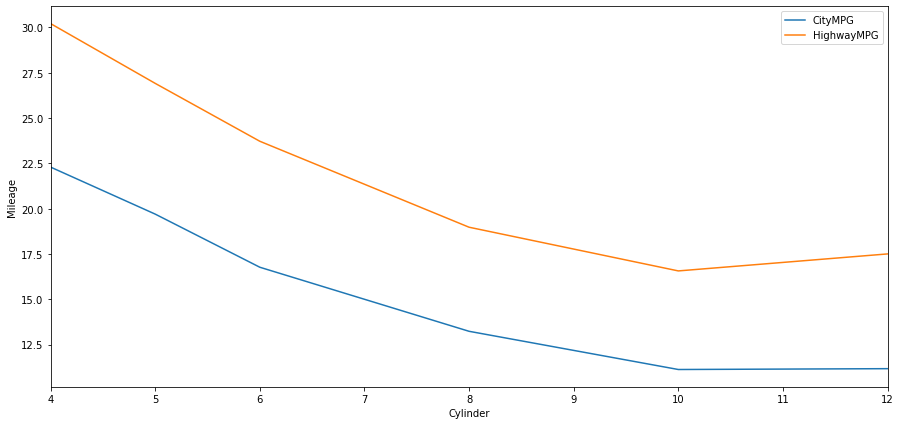

In [8]:
# Data Analysis

# creating line graph of Mileage vs Number of cylinder car has.

df.sort_values(by=['Cylinder'],inplace=True)

fig, ax = plt.subplots(figsize=(15,7))
ax.set_ylabel("Mileage")
df.groupby(['Cylinder']).mean()[['CityMPG','HighwayMPG']].plot(ax=ax)


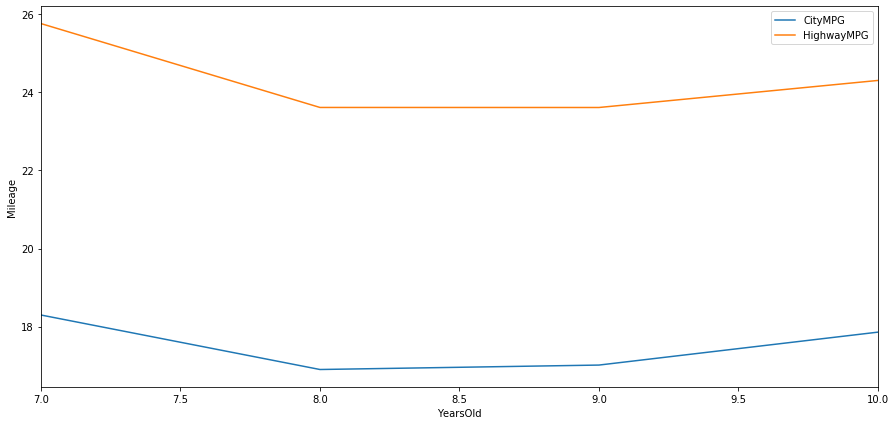

In [9]:
# creating line graph of Mileage vs years old car is.

df.sort_values(by=['YearsOld'],inplace=True)

fig, ax = plt.subplots(figsize=(15,7))
ax.set_ylabel("Mileage")
df.groupby(['YearsOld']).mean()[['CityMPG','HighwayMPG']].plot(ax=ax)

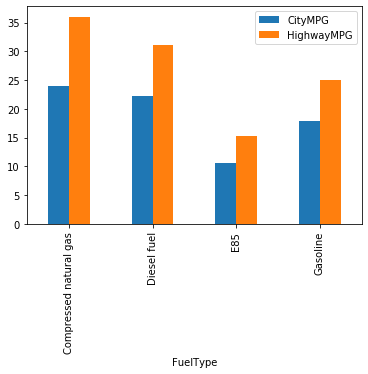

In [10]:
# creating bar plot of Mileage vs fuel type car uses 

df.groupby(['FuelType'])[['CityMPG','HighwayMPG']].mean().plot.bar()


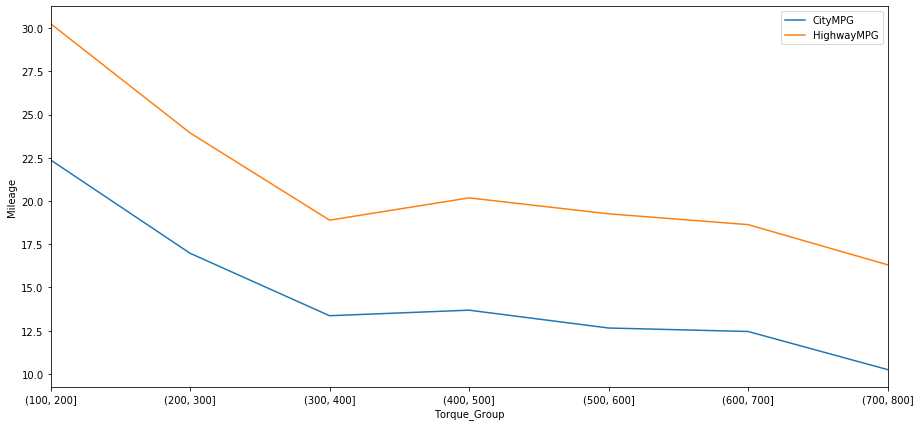

In [11]:
# creating line graph of Mileage vs Torque of the car engine

bins = pd.IntervalIndex.from_tuples([(100, 200), (200,  300), (300, 400), (400, 500),(500,600),(600,700),(700,800)])
df['Torque_Group'] = pd.cut(df['Torque'], bins)

df.sort_values(by=['Torque_Group'],inplace=True)

fig, ax = plt.subplots(figsize=(15,7))
ax.set_ylabel("Mileage")
df.groupby(['Torque_Group']).mean()[['CityMPG','HighwayMPG']].plot(ax=ax)

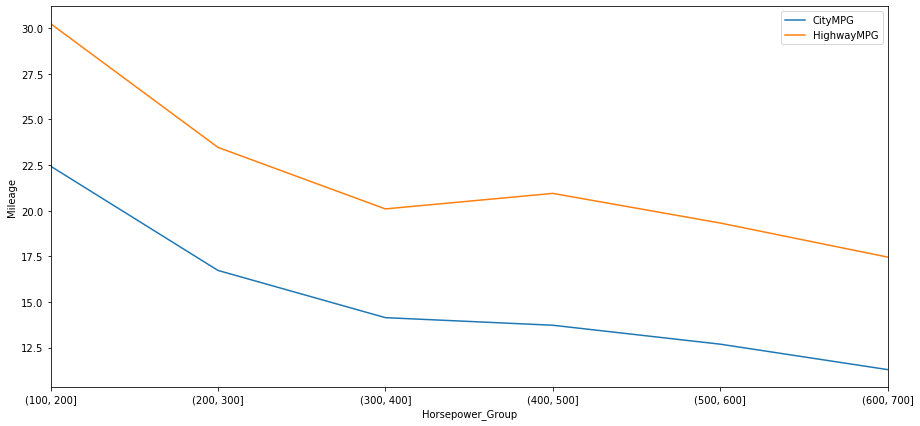

In [12]:
# creating line garph of Mileage vs horsepower of car engine

bins = pd.IntervalIndex.from_tuples([(100, 200), (200,  300), (300, 400), (400, 500),(500,600),(600,700)])
df['Horsepower_Group'] = pd.cut(df['Horsepower'], bins)

df.sort_values(by=['Horsepower_Group'],inplace=True)

fig, ax = plt.subplots(figsize=(15,7))
ax.set_ylabel("Mileage")
df.groupby(['Horsepower_Group']).mean()[['CityMPG','HighwayMPG']].plot(ax=ax)

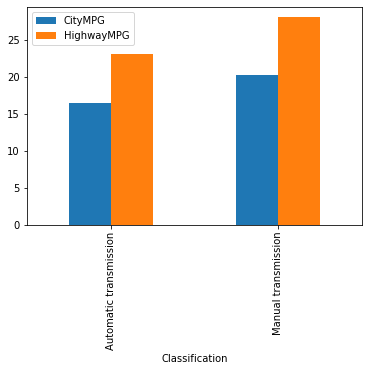

In [13]:
# creating bar plot of Mileage vs Classification type of car
df.groupby(['Classification'])[['CityMPG','HighwayMPG']].mean().plot.bar()

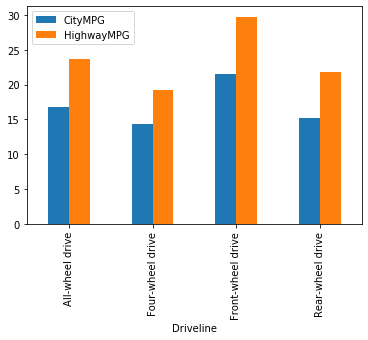

In [14]:
# creating bar plot of Mileage vs Driveline type
df.groupby(['Driveline'])[['CityMPG','HighwayMPG']].mean().plot.bar()

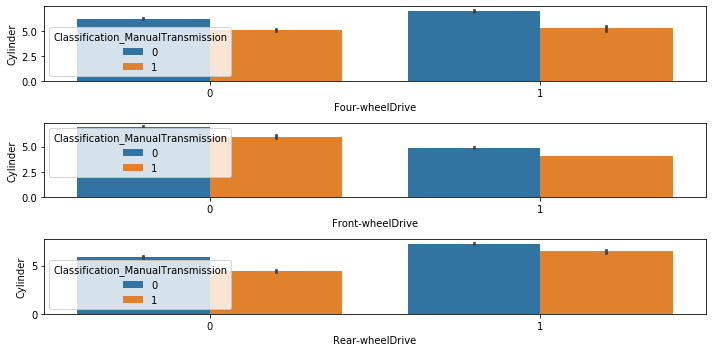

In [15]:
#plot based on tranmission classification
#Four wheel drive and Cylinder
#Front wheel drive and Cylinder
#Rear wheel drive and Cylinder
fig, axes = plt.subplots(3, 1, figsize = (10, 5))
sns.barplot(x = 'Four-wheelDrive', y = 'Cylinder', hue = 'Classification_ManualTransmission', data = df, ax = axes[0])
sns.barplot(x = 'Front-wheelDrive', y = 'Cylinder', hue = 'Classification_ManualTransmission', data = df, ax = axes[1])
sns.barplot(x = 'Rear-wheelDrive', y = 'Cylinder', hue = 'Classification_ManualTransmission', data = df, ax = axes[2])
plt.tight_layout()

[1.0, 0.5397848410541733]


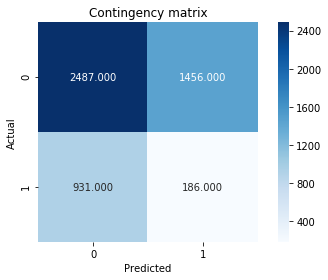

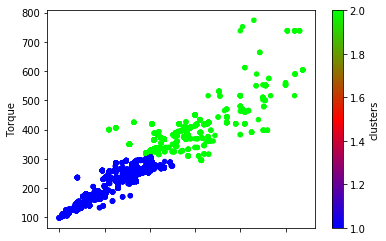

In [16]:
#Complete linkage clusetering on predictor variables
#Horsepower, Torque, CityMPG, and HighwayMPG

X = df[['Horsepower', 'Torque','CityMPG','HighwayMPG']]

clustering = linkage(X, method = "complete", metric = "euclidean")
clusters = fcluster(clustering, 2, criterion = 'maxclust')

# Plot contingency matrix and compute evaluation metrics for hierarchical clustering with complete linkage method.
df['clusters'] = clusters - 1
cont_matrix = metrics.cluster.contingency_matrix(df['Classification_ManualTransmission'], clusters)
sns.heatmap(cont_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Contingency matrix')
plt.tight_layout()

adjusted_rand_index = metrics.adjusted_rand_score(clusters, df['clusters'])
silhouette_coefficient = metrics.silhouette_score(X, clusters, metric = "euclidean")
print([adjusted_rand_index, silhouette_coefficient])

# Plot clusters found using hierarchical clustering with single linkage method
df['clusters'] = clusters
ax = df.plot(kind = 'scatter', x = 'Horsepower', y = 'Torque', c = 'clusters', colormap = plt.cm.brg)

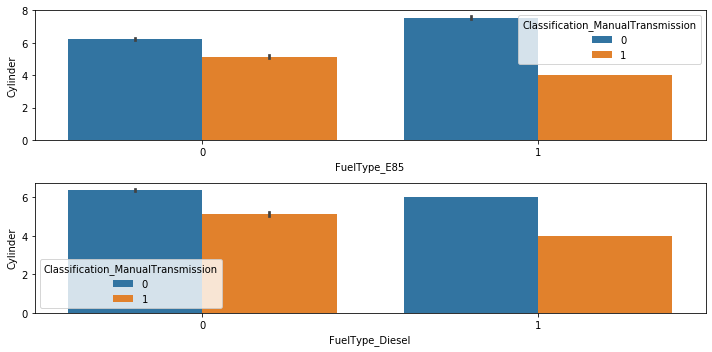

In [17]:
#plot based on tranmission classification
#FuelType_E85 and Cylinder
#FuelType_Diesel drive and Cylinder
fig, axes = plt.subplots(2, 1, figsize = (10, 5))
sns.barplot(x = 'FuelType_E85', y = 'Cylinder', hue = 'Classification_ManualTransmission', data = df, ax = axes[0])
sns.barplot(x = 'FuelType_Diesel', y = 'Cylinder', hue = 'Classification_ManualTransmission', data = df, ax = axes[1])
plt.tight_layout()

In [18]:
# Partition dataset into training and test sets
# In this we are only taking the columns which are numerical in category as we need only those attributes 
# will get use for both test and training purpose. 
x_train, x_test, y_train, y_test = train_test_split(df[['DimensionsHeight', 'DimensionsLength', 'DimensionsWidth',
       'ForwardGears',
        'Horsepower',
       'Torque', 'Four-wheelDrive', 'Front-wheelDrive', 'Rear-wheelDrive',
       'FuelType_Diesel', 'FuelType_E85', 'FuelType_Gasoline',
       'Classification_ManualTransmission', 'Cylinder', 'YearsOld']],
                                                    df[['CityMPG','HighwayMPG']], test_size=0.25, random_state = 0)




In [19]:
# Resetting index so that we can later do the concat with the categorical column which are not passed for scaling
x_train.reset_index(inplace=True)
x_test.reset_index(inplace=True)

# so that we can use them in model training and predicting as index has to be same for both input and output dataframe 
y_train.reset_index(inplace=True)
y_test.reset_index(inplace=True)

In [20]:
x_train_columns_to_scale = ['DimensionsHeight', 'DimensionsLength', 'DimensionsWidth','ForwardGears',
        'Horsepower',
       'Torque','Cylinder','YearsOld']

In [21]:
# Standardizing the data 
# using train parameters only we are also scaling the test data as in real use case we doesn't have test parameters.
# doing scaling of only needed variable i.e. which are not categorical.
scaler = StandardScaler()
scaler.fit(x_train[['DimensionsHeight', 'DimensionsLength', 'DimensionsWidth','ForwardGears','Horsepower','Torque','Cylinder','YearsOld']])


x_train_scaled = scaler.transform(x_train[['DimensionsHeight', 'DimensionsLength', 'DimensionsWidth','ForwardGears','Horsepower','Torque','Cylinder','YearsOld']]) 

# adding column name and converting it to dataframe.
x_train_scaled = pd.DataFrame(x_train_scaled, columns = x_train_columns_to_scale)

# adding the categorical columns which we have not passed during scaling.
x_train_scaled = pd.concat([x_train_scaled,x_train[['Four-wheelDrive', 'Front-wheelDrive', 'Rear-wheelDrive',
       'FuelType_Diesel', 'FuelType_E85', 'FuelType_Gasoline',
       'Classification_ManualTransmission']]],axis=1)

x_test_scaled = scaler.transform(x_test[['DimensionsHeight', 'DimensionsLength', 'DimensionsWidth','ForwardGears','Horsepower','Torque','Cylinder','YearsOld']])
# adding column name and converting it to dataframe.
x_test_scaled = pd.DataFrame(x_test_scaled, columns = x_train_columns_to_scale )
# adding the categorical columns which we have not passed during scaling.
x_test_scaled = pd.concat([x_test_scaled,x_test[['Four-wheelDrive', 'Front-wheelDrive', 'Rear-wheelDrive',
       'FuelType_Diesel', 'FuelType_E85', 'FuelType_Gasoline','Classification_ManualTransmission']]],axis=1)

x_complete_scaled = scaler.transform(df[['DimensionsHeight', 'DimensionsLength', 'DimensionsWidth','ForwardGears','Horsepower','Torque','Cylinder','YearsOld']])

# adding column name and converting it to dataframe.
x_complete_scaled = pd.DataFrame(x_complete_scaled, columns = x_train_columns_to_scale)

#adding the categorical columns which we have not passed during scaling.
x_complete_scaled = pd.concat([x_complete_scaled,df[['Four-wheelDrive', 'Front-wheelDrive', 'Rear-wheelDrive',
       'FuelType_Diesel', 'FuelType_E85', 'FuelType_Gasoline',
       'Classification_ManualTransmission']]],axis=1)


In [22]:
#Regression model for CityMPG
#Creating model to predict *CityMPG* based on the following columns

# 1.'YearsOld'
# 2. 'FuelType_Diesel','FuelType_E85','FuelType_Gasoline'
# 3. 'Classification_ManualTransmission'
# 4. 'Horsepower',
# 5. 'Torque',
# 6. 'Cylinder',                                                   
# 7. 'Four-wheelDrive','Front-wheelDrive','Rear-wheelDrive',
# 8. 'DimensionsHeight','DimensionsLength','DimensionsWidth'

model_city = linear_model.LinearRegression()
fitted_model_city = model_city.fit(x_train_scaled[['YearsOld',
                                                   'FuelType_Diesel','FuelType_E85','FuelType_Gasoline',
                                                   'Classification_ManualTransmission',
                                                   'Horsepower',
                                                   'Torque','Cylinder',
                                                   'Four-wheelDrive','Front-wheelDrive','Rear-wheelDrive',
                                                   'DimensionsHeight','DimensionsLength','DimensionsWidth'
                                                   
                                                  ]],y_train['CityMPG'])

y_pred_city = fitted_model_city.predict(x_test_scaled[['YearsOld',
                                                   'FuelType_Diesel','FuelType_E85','FuelType_Gasoline',
                                                   'Classification_ManualTransmission',
                                                   'Horsepower',
                                                   'Torque','Cylinder',
                                                   'Four-wheelDrive','Front-wheelDrive','Rear-wheelDrive',
                                                   'DimensionsHeight','DimensionsLength','DimensionsWidth'
                                                   ]])


print('Model Coefficient of cityMPG:',fitted_model_city.coef_)

#calculating Adjusted R_Square Value of the model since we have multiple predictor variables
corr_coef = np.corrcoef(y_test['CityMPG'],y_pred_city)[1, 0]
R_squared = corr_coef**2
print('R_squared:',R_squared)
adjusted_r_square = 1-(((1-R_squared)*(x_test.shape[0]-1))/(x_test.shape[0]-14-1))
print('adjusted_r_square :',adjusted_r_square)



Model Coefficient of cityMPG: [-0.19086698  3.48070031 -5.64562821 -0.92801775  0.98791555  0.41662751
 -1.51556939 -1.51059878 -0.99077217  2.22123201  0.11134555  0.18122584
  0.0672529   0.31756989]
R_squared: 0.8149589948309959
adjusted_r_square : 0.812886535573103


In [23]:
pred_complete_cityMPG = fitted_model_city.predict(x_complete_scaled[['YearsOld',
                                                   'FuelType_Diesel','FuelType_E85','FuelType_Gasoline',
                                                   'Classification_ManualTransmission',
                                                   'Horsepower',
                                                   'Torque','Cylinder',
                                                   'Four-wheelDrive','Front-wheelDrive','Rear-wheelDrive',
                                                   'DimensionsHeight','DimensionsLength','DimensionsWidth'
                                                   ]])


df['pred_CityMPG'] = pred_complete_cityMPG

In [24]:
#Regression model for HighwayMPG
#Creating model to predict *HighwayMPG* based on the following columns
# 1.'YearsOld'
# 2. 'FuelType_Diesel','FuelType_E85','FuelType_Gasoline'
# 3. 'Classification_ManualTransmission'
# 4. 'Horsepower',
# 5. 'Torque',
# 6. 'Cylinder',                                                   
# 7. 'Four-wheelDrive','Front-wheelDrive','Rear-wheelDrive',
# 8. 'DimensionsHeight','DimensionsLength','DimensionsWidth'

model_highwayMPG = linear_model.LinearRegression()
fitted_model_highwayMPG = model_highwayMPG.fit(x_train_scaled[['YearsOld',
                                                   'FuelType_Diesel','FuelType_E85','FuelType_Gasoline',
                                                   'Classification_ManualTransmission',
                                                   'Horsepower',
                                                   'Torque','Cylinder',
                                                   'Four-wheelDrive','Front-wheelDrive','Rear-wheelDrive',
                                                    'DimensionsHeight','DimensionsLength','DimensionsWidth'
                                                  ]],y_train['HighwayMPG'])

y_pred_highwayMPG = fitted_model_highwayMPG.predict(x_test_scaled[['YearsOld',
                                                   'FuelType_Diesel','FuelType_E85','FuelType_Gasoline',
                                                   'Classification_ManualTransmission',
                                                   'Horsepower',
                                                   'Torque','Cylinder',
                                                   'Four-wheelDrive','Front-wheelDrive','Rear-wheelDrive',
                                                    'DimensionsHeight','DimensionsLength','DimensionsWidth'
                                                   ]])

print('Model Coefficient of highwayMPG:',fitted_model_highwayMPG.coef_)

#calculating Adjusted R_Square Value of the model since we have multiple predictor variables
corr_coef = np.corrcoef(y_test['HighwayMPG'],y_pred_highwayMPG)[1, 0]
R_squared = corr_coef**2
print('R_squared:',R_squared)
adjusted_r_square = 1-(((1-R_squared)*(x_train_scaled.shape[0]-1))/(x_train_scaled.shape[0]-14-1))
print('adjusted_r_square :',adjusted_r_square)




Model Coefficient of highwayMPG: [ -0.36848049   2.30535562 -11.49813727  -5.15801274   1.23059854
   1.68277827  -2.2707133   -2.15449565  -1.96267892   3.59795013
   0.52176918   0.29797584   0.14418514   0.17706032]
R_squared: 0.792964654392592
adjusted_r_square : 0.7921978568162682


In [25]:
pred_complete_highwayMPG = fitted_model_highwayMPG.predict(x_complete_scaled[['YearsOld',
                                                   'FuelType_Diesel','FuelType_E85','FuelType_Gasoline',
                                                   'Classification_ManualTransmission',
                                                   'Horsepower',
                                                   'Torque','Cylinder',
                                                   'Four-wheelDrive','Front-wheelDrive','Rear-wheelDrive',
                                                    'DimensionsHeight','DimensionsLength','DimensionsWidth'
                                                   ]])



df['Pred_HighwayMPG']=pred_complete_highwayMPG

In [26]:
df[['Pred_HighwayMPG','HighwayMPG','CityMPG','pred_CityMPG']]

,Pred_HighwayMPG,HighwayMPG,CityMPG,pred_CityMPG
575,26.256390,34,23,19.334612
578,29.854340,31,22,21.555844
3672,30.743995,27,19,22.355325
24,25.689998,25,18,19.326062
1229,26.954206,30,21,19.841581
4600,27.687812,31,24,20.812794
3601,26.075841,23,17,19.626370
4599,26.457213,33,23,19.824878
2476,26.116107,30,22,19.901722
2239,27.739664,29,23,21.153510


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0.708300395256917, 0.291699604743083, array([0.9003881 , 0.40650407]), array([0.70445344, 0.72202166]), array([0.79045997, 0.52015605])]


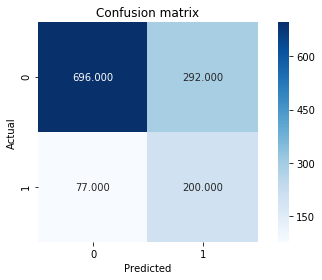

In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(df[['Horsepower','Torque', 'Rear-wheelDrive',
     'Cylinder', 'CityMPG', 'HighwayMPG', 'ForwardGears', 'FuelType_E85', 'FuelType_Diesel']],df[['Classification_ManualTransmission']], test_size=0.25, random_state = 0)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#naive bayes
naive_classifier = GaussianNB()  
naive_classifier.fit(X_train_scaled, Y_train)

Y_pred = naive_classifier.predict(X_test_scaled)

conf_matrix = metrics.confusion_matrix(Y_test['Classification_ManualTransmission'], Y_pred)
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

accuracy = metrics.accuracy_score(Y_test['Classification_ManualTransmission'], Y_pred)
error = 1 - accuracy
precision = metrics.precision_score(Y_test['Classification_ManualTransmission'], Y_pred, average = None)
recall = metrics.recall_score(Y_test['Classification_ManualTransmission'], Y_pred, average = None)
F1_score = metrics.f1_score(Y_test['Classification_ManualTransmission'], Y_pred, average = None)
print([accuracy, error, precision, recall, F1_score])